In [1]:
# Imports
# Load the TensorBoard notebook extension
import cv2
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Declare preprocessing functions
img_size = 128
def get_label(file_path: str):
    parsed = tf.strings.split(file_path, os.path.sep)
    parent = parsed[-2]
    file_name = parsed[-1]
    if parent == "PNEUMONIA":
        label_str = tf.strings.split(file_name, '_')[1]
    else:
        label_str = parent
    return tf.argmax(label_str == class_names)


def decode_img(img):
    
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3, dtype= tf.dtypes.uint8)

    # Check the number of channels
    num_channels = tf.shape(img)[-1]

    # Convert grayscale to RGB if necessary
    if num_channels == 1:
        print("grayscale")
        img = np.repeat(img, 3, axis=-1)
    # get image dimensions
    img_shape = tf.shape(img).numpy()

    width, height = img_shape[0], img_shape[1]
    min_dimension = tf.math.minimum(width, height).numpy()

    crop_size = tf.constant([min_dimension, min_dimension, 3], dtype='int32')
    # Implement random cropping
    img = tf.image.random_crop(value=img, size=crop_size)
    img = tf.cast(img, tf.float32)/255 # Explicitly cast to float32 and normalize
    return tf.image.resize(img, [img_size, img_size], method='nearest', preserve_aspect_ratio=False)


@tf.function
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.py_function(decode_img, [img], tf.float32)
    return img, label

@tf.function
def process_path_and_augment(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.py_function(decode_img, [img], tf.float32)
    img = tf.py_function(data_augmentation, [img], tf.float32)

    return img, label


def data_augmentation(image):
    # Apply data augmentation operations to the image

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    return image



In [1]:
# Preprocessing
class_names = np.array(['NORMAL', 'bacteria', 'virus'])


# path_to_dir = os.environ.get("DATASET_PATH")
path_to_dir = "/Volumes/KINGSTON/Pnemonia Dataset/chest_xray"
if path_to_dir is None:
    os.environ["DATASET_PATH"] = input("Enter complete path to the chest_xray folder: ")
    path_to_dir = os.environ["DATASET_PATH"]
    print("You should set the DATASET_PATH enviroment variable to avoid this every time you run the program.")



ds_files = [str(file.absolute()) for file in pathlib.Path(path_to_dir).glob("**/[!._]*.jp*g")]

# There's 2x more baceria samples than normal and viral.
# removing some bacterial examples to even out the dataset.
# This will help the model generalize better.
progress = 0
bacteria_count = 0
for file in ds_files:
    if progress % 500 == 0:
        print(f"images sorted: {progress}")
    if class_names[get_label(file)] == "bacteria":
        bacteria_count += 1
        if bacteria_count%2 == 0:
            ds_files.remove(file)
    progress += 1



list_ds = tf.data.Dataset.from_tensor_slices(ds_files)
image_count = len(ds_files)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

for f in list_ds.take(5):
    print(f.numpy())

class_names = np.array(['NORMAL', 'bacteria', 'virus'])

val_size = int(image_count * 0.3)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)






NameError: name 'np' is not defined

Image shape:  (128, 128, 3)
Label:  2
Label Shape:  ()
Type:  virus


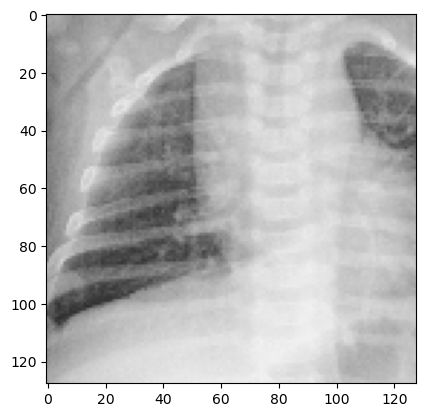

Image shape:  (128, 128, 3)
Label:  2
Label Shape:  ()
Type:  virus


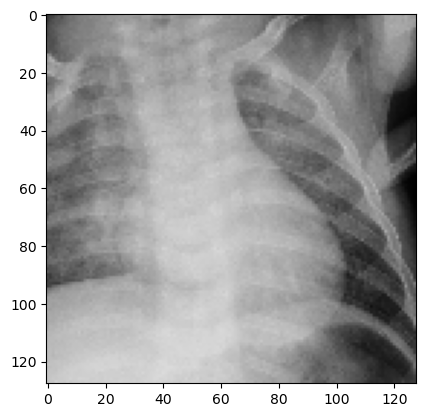

Image shape:  (128, 128, 3)
Label:  0
Label Shape:  ()
Type:  NORMAL


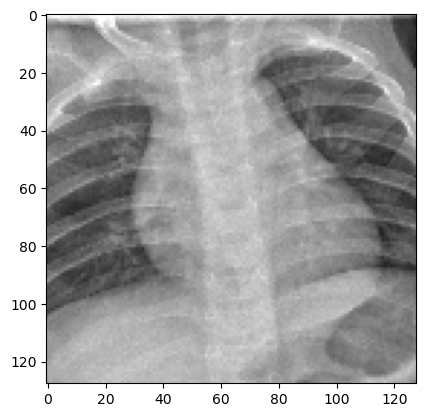

In [4]:
# View sample of dataset

for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("Label Shape: ", label.numpy().shape)
    print("Type: ", class_names[label.numpy()])
    plt.imshow(image.numpy())
    plt.show()

view_dist = input("Would you like to view the sample distribution? (Y/n)\n>> ")
if view_dist=='Y':
    # View distrobution of samples:
    count = {"NORMAL": 0,
             "bacteria": 0,
             "virus": 0}
    for image, label in train_ds:
        count[class_names[label]] += 1

    plt.bar(class_names, count.values(), color='red')
    plt.xlabel('Class Names')
    plt.ylabel('Counts')
    plt.title('Training Distribution')
    plt.xticks(rotation=45)
    plt.show()

# View distrobution of samples:
    count = {"NORMAL": 0,
             "bacteria": 0,
             "virus": 0}
    for image, label in val_ds:
        count[class_names[label]] += 1

    plt.bar(class_names, count.values(), color='red')
    plt.xlabel('Class Names')
    plt.ylabel('Counts')
    plt.title('Testing Distribution')
    plt.xticks(rotation=45)
    plt.show()



In [5]:
# Sample model using MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable=False
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))



model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2586691 (9.87 MB)
Trainable params: 3287

Training set size:  3392
Validation set size:  1472
53
Epoch 1/12
53/53 [==============================] - 30s 552ms/step - loss: 0.7726 - accuracy: 0.6598 - val_loss: 0.5745 - val_accuracy: 0.7434
Epoch 2/12
53/53 [==============================] - 29s 548ms/step - loss: 0.6066 - accuracy: 0.7365 - val_loss: 0.5384 - val_accuracy: 0.7649
Epoch 3/12
53/53 [==============================] - 28s 517ms/step - loss: 0.5689 - accuracy: 0.7466 - val_loss: 0.5557 - val_accuracy: 0.7490
Epoch 4/12
53/53 [==============================] - 30s 572ms/step - loss: 0.5573 - accuracy: 0.7513 - val_loss: 0.5040 - val_accuracy: 0.7725
Epoch 5/12
53/53 [==============================] - 30s 566ms/step - loss: 0.5432 - accuracy: 0.7602 - val_loss: 0.4859 - val_accuracy: 0.7739
Epoch 6/12
53/53 [==============================] - 59s 1s/step - loss: 0.5209 - accuracy: 0.7709 - val_loss: 0.4816 - val_accuracy: 0.7850
Epoch 7/12
53/53 [==============================] - 50s 946ms/step - loss: 0.5280 - accura

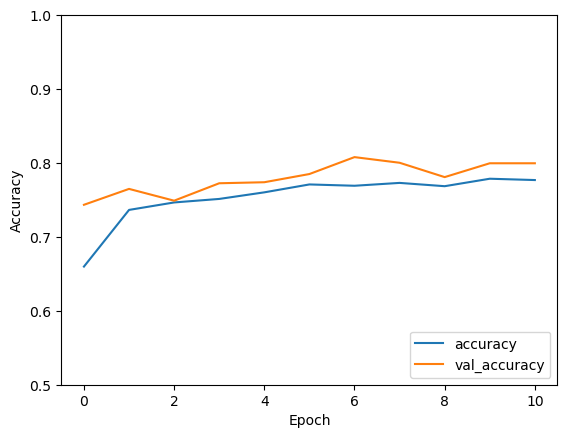

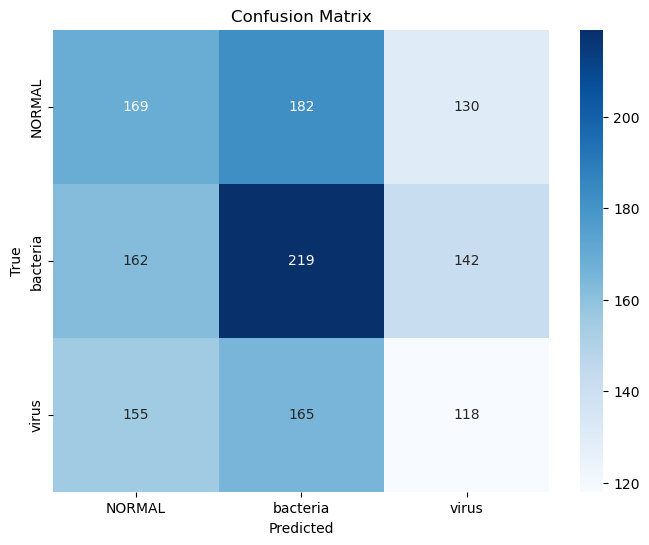

In [11]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
# Batching
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

print('Training set size: ', len(train_ds)*batch_size)
print('Validation set size: ', len(val_ds)*batch_size)

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Define number of epochs and steps per epoch
epochs = 12
steps_per_epoch = len(train_ds)
validation_steps = len(val_ds) 

print(steps_per_epoch)


# Train the model using model.fit
history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(val_ds, verbose=2)
y_pred_probabilities = model.predict(val_ds)
y_true = []
for _, label in val_ds:
    y_true.append(label.numpy())

y_true_stacks = [np.argmax(label.numpy(), axis=1) if len(label.numpy().shape) > 1 else label.numpy() for _, label in val_ds]
y_true_classes = np.concatenate(y_true_stacks, axis=0)

y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
confusion = confusion_matrix(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [12]:
model.save("xray_model_post_train2.keras")

In [13]:
# Unfreeze convolutional layers, then make a new model with those layers
fine_model = models.Sequential()
for layer in model.layers[:-4]:
    layer.trainable = True
    fine_model.add(layer)
fine_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
fine_model.add(layers.MaxPooling2D((2, 2)))
fine_model.add(layers.Dropout(0.1))
fine_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
fine_model.add(layers.Flatten())
fine_model.add(layers.Dense(64, activation='relu'))
fine_model.add(layers.Dropout(0.3))
fine_model.add(layers.Dense(3, activation='softmax'))

fine_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

epochs = 20

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model_fine_tune_v3.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


# Train the model using model.fit
history = fine_model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = fine_model.evaluate(val_ds, verbose=2)

#test_loss, test_acc = model.evaluate(val_ds, verbose=2)
y_pred_probabilities = model.predict(val_ds)
y_true = []
for _, label in val_ds:
    y_true.append(label.numpy())

y_true_stacks = [np.argmax(label.numpy(), axis=1) if len(label.numpy().shape) > 1 else label.numpy() for _, label in val_ds]
y_true_classes = np.concatenate(y_true_stacks, axis=0)

y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
confusion = confusion_matrix(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/20


In [ ]:
## Now, let's just train the dense layers

for layer in fine_model.layers[:-4]:
    layer.trainable = False

fine_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

epochs = 100

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model_fine_tune_v4.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


# Train the model using model.fit
history = fine_model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(val_ds, verbose=2)
y_pred_probabilities = model.predict(val_ds)
y_true = []
for _, label in val_ds:
    y_true.append(label.numpy())

y_true_stacks = [np.argmax(label.numpy(), axis=1) if len(label.numpy().shape) > 1 else label.numpy() for _, label in val_ds]
y_true_classes = np.concatenate(y_true_stacks, axis=0)

y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
confusion = confusion_matrix(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/100
50/61 [=======================>......] - ETA: 4s - loss: 0.5636 - accuracy: 0.7453

KeyboardInterrupt: 